In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from dabl import detect_types
import seaborn as sns
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import spacy
import re 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool, cv
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
import graphviz
from sklearn.tree import export_graphviz


import warnings
warnings.filterwarnings('ignore')

In [2]:
df_airbnb = pd.read_csv('listings.csv')

df_airbnb

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,53996003,https://www.airbnb.com/rooms/53996003,20231212054032,2023-12-12,city scrape,Rental unit in St Leonards · ★4.66 · 1 bedroom...,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,153195376,...,4.85,4.86,4.69,PID-STRA-30910,f,6,6,0,0,2.73
1,883656189858403878,https://www.airbnb.com/rooms/883656189858403878,20231212054032,2023-12-12,city scrape,Rental unit in Coogee · 1 bedroom · 1 bed · 1 ...,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,23868355,...,5.00,5.00,5.00,PID-STRA-52221,f,1,0,1,0,0.15
2,883870891812565255,https://www.airbnb.com/rooms/883870891812565255,20231212054032,2023-12-13,city scrape,Rental unit in McMahons Point · ★4.63 · 2 bedr...,NaN,McMahons Point is a picturesque and affluent H...,https://a0.muscache.com/pictures/prohost-api/H...,279001183,...,5.00,4.75,4.50,PID-STRA-45906,f,245,245,0,0,1.29
3,8688488,https://www.airbnb.com/rooms/8688488,20231212054032,2023-12-12,previous scrape,Rental unit in Manly · 1 bedroom · 1 bed · 1 bath,NaN,NaN,https://a0.muscache.com/pictures/fbcc5710-269e...,5870556,...,5.00,5.00,4.00,NaN,f,1,1,0,0,0.01
4,1029336597495719710,https://www.airbnb.com/rooms/1029336597495719710,20231213185037,2023-12-14,city scrape,Home in South West Rocks · ★New · 3 bedrooms ·...,NaN,NaN,https://a0.muscache.com/pictures/prohost-api/H...,363191034,...,NaN,NaN,NaN,PID-STRA-51457,t,29,29,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37631,852378516393307925,https://www.airbnb.com/rooms/852378516393307925,20231218032523,2023-12-18,city scrape,Rental unit in Evans Head · 2 bedrooms · 3 bed...,NaN,NaN,https://a0.muscache.com/pictures/prohost-api/H...,506489569,...,NaN,NaN,NaN,PID-STRA-23751,t,31,31,0,0,NaN
37632,9671101,https://www.airbnb.com/rooms/9671101,20231212054032,2023-12-12,previous scrape,Home in Coogee · ★4.67 · 4 bedrooms · 5 beds ·...,NaN,NaN,https://a0.muscache.com/pictures/c2308ac8-80ab...,49975536,...,5.00,4.33,4.67,NaN,f,1,1,0,0,0.03
37633,27840798,https://www.airbnb.com/rooms/27840798,20231212054032,2023-12-12,city scrape,Place to stay in Bilgola Plateau · ★4.65 · 1 b...,NaN,"There are a number of unique, short rainforest...",https://a0.muscache.com/pictures/ad87dd4d-801f...,167867446,...,4.90,4.81,4.73,Exempt,t,1,1,0,0,5.44
37634,934659970420350565,https://www.airbnb.com/rooms/934659970420350565,20231212054032,2023-12-12,city scrape,Rental unit in Rose Bay · 2 bedrooms · 2 beds ...,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,429559094,...,NaN,NaN,NaN,PID-STRA-54124,f,1,1,0,0,NaN


# EDA

## Target Variable

In [3]:
df_airbnb['price'].isna().sum()

2006

In [4]:
df_airbnb['price'] = df_airbnb['price'].replace('[\$,]', '', regex=True).astype(float)
df_airbnb = df_airbnb.dropna(subset=['price'])

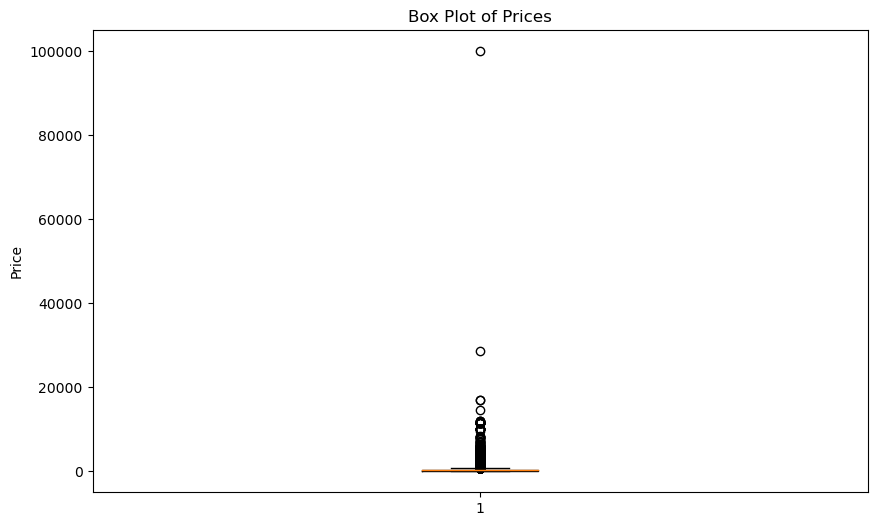

In [5]:
plt.figure(figsize=(10, 6))
plt.boxplot(df_airbnb['price'])
plt.title('Box Plot of Prices')
plt.ylabel('Price')
plt.show()

In [6]:
df_airbnb = df_airbnb[df_airbnb['price'] > 0]
df_airbnb = df_airbnb[df_airbnb['price'] <= 10000]

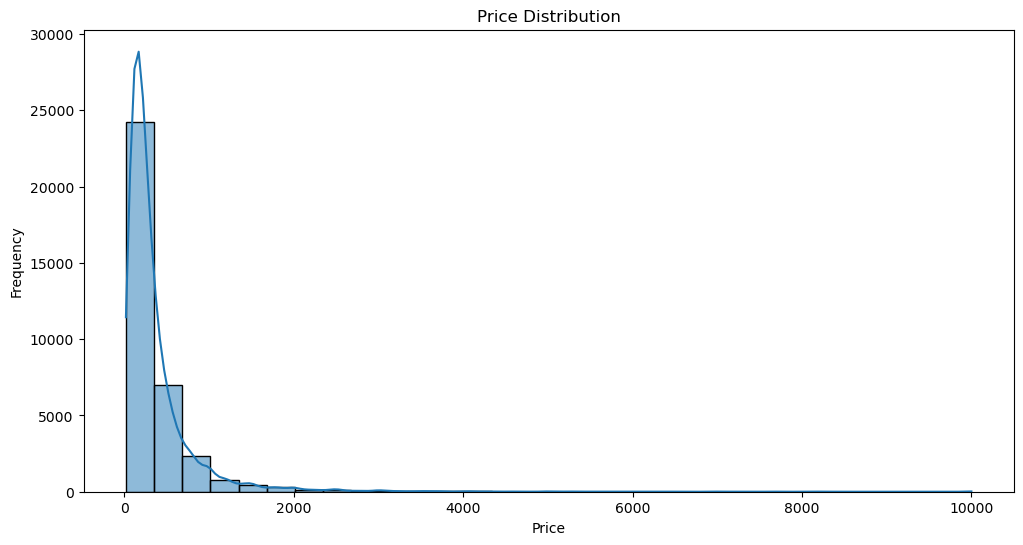

In [7]:
plt.figure(figsize=(12, 6))
sns.histplot(df_airbnb['price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [8]:
price_skewness = skew(df_airbnb['price'])
price_kurtosis = kurtosis(df_airbnb['price'])

print(f'price skewness: {price_skewness}')
print(f'price kurtosis: {price_kurtosis}')

price skewness: 6.552399653025734
price kurtosis: 76.01117421664355


In [9]:
# Logtransformation
df_airbnb['log_price'] = np.log(df_airbnb['price'])  
df_airbnb.drop(columns=['price'], inplace=True)

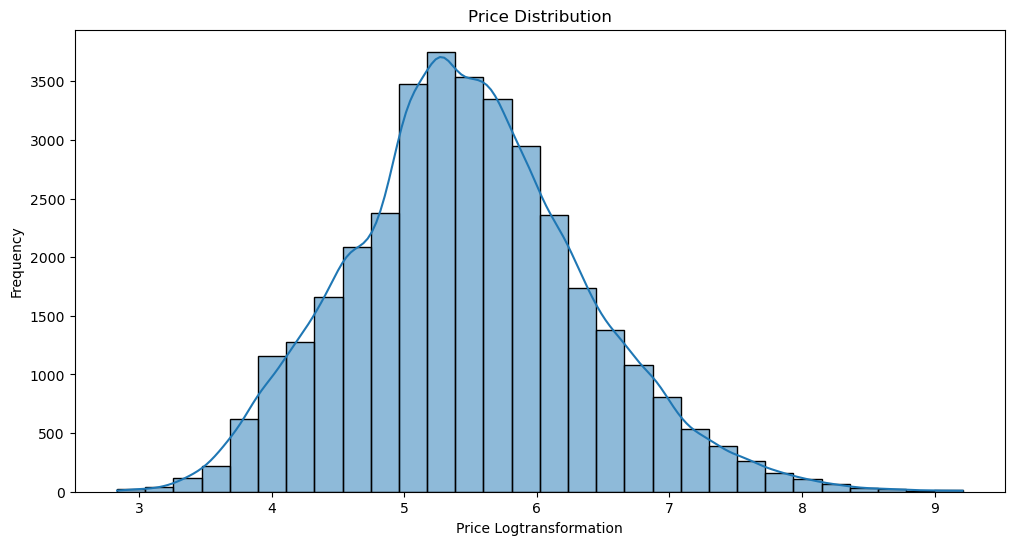

In [10]:
plt.figure(figsize=(12, 6))
sns.histplot(df_airbnb['log_price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price Logtransformation')
plt.ylabel('Frequency')
plt.show()


In [11]:
log_price_skewness = skew(df_airbnb['log_price'])
log_price_kurtosis = kurtosis(df_airbnb['log_price'])

print(f'log price skewness: {log_price_skewness}')
print(f'log price kurtosis: {log_price_kurtosis}')

log price skewness: 0.30188154901455666
log price kurtosis: 0.21744719343745134


## Useless Variable

In [12]:
detected_columns = detect_types(df_airbnb)
detected_columns

,continuous,dirty_float,low_card_int_ordinal,low_card_int_categorical,categorical,date,free_string,useless
id,True,False,False,False,False,False,False,False
listing_url,False,False,False,False,False,False,True,False
scrape_id,False,False,False,False,True,False,False,False
last_scraped,False,False,False,False,False,True,False,False
source,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...
calculated_host_listings_count_entire_homes,False,False,True,False,False,False,False,False
calculated_host_listings_count_private_rooms,False,False,True,False,False,False,False,False
calculated_host_listings_count_shared_rooms,False,False,False,False,False,False,False,True
reviews_per_month,True,False,False,False,False,False,False,False


In [13]:
useless_columns = detected_columns[detected_columns['useless'] == True]
useless_columns

,continuous,dirty_float,low_card_int_ordinal,low_card_int_categorical,categorical,date,free_string,useless
description,False,False,False,False,False,False,False,True
host_has_profile_pic,False,False,False,False,False,False,False,True
neighbourhood_group_cleansed,False,False,False,False,False,False,False,True
bathrooms,False,False,False,False,False,False,False,True
bedrooms,False,False,False,False,False,False,False,True
amenities,False,False,False,False,False,False,False,True
calendar_updated,False,False,False,False,False,False,False,True
calculated_host_listings_count_shared_rooms,False,False,False,False,False,False,False,True


In [14]:
# 查找所有非数值类型的列（如文本、URL等）
non_numeric_columns = df_airbnb.select_dtypes(include=['object']).columns
print(non_numeric_columns)

Index(['listing_url', 'last_scraped', 'source', 'name',
       'neighborhood_overview', 'picture_url', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type',
       'bathrooms_text', 'amenities', 'has_availability',
       'calendar_last_scraped', 'first_review', 'last_review', 'license',
       'instant_bookable'],
      dtype='object')


In [15]:
remove_columns = ['listing_url','last_scraped','source','name','picture_url','description',
                  'host_since','host_location','host_about','host_acceptance_rate',
                  'host_thumbnail_url','host_picture_url','host_neighbourhood','host_response_time',
                  'host_neighbourhood','host_verifications','neighbourhood','bathrooms',
                  'amenities','calendar_last_scraped','first_review','number_of_reviews_l30d',
                  'last_review','license','neighbourhood_group_cleansed','bedrooms','calendar_updated',
                  'calculated_host_listings_count_shared_rooms','id','scrape_id',
                  'host_id','host_url','host_name','host_listings_count','host_total_listings_count',
                  'latitude','longitude','minimum_nights','maximum_nights',
                  'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights',
                  'maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm',
                  'number_of_reviews_ltm','calculated_host_listings_count_entire_homes',
                  'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
                  'reviews_per_month']

df_airbnb = df_airbnb.drop(remove_columns, axis=1)

In [16]:
df_airbnb.columns

Index(['neighborhood_overview', 'host_response_rate', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'beds', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count', 'log_price'],
      dtype='object')

## Numeric Variable

In [17]:
# score_columns
score_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                 'review_scores_checkin', 'review_scores_communication',
                 'review_scores_location', 'review_scores_value']

def rescore(x):
    if pd.isna(x):
        return 0
    elif 0 < x < 4:
        return 1
    elif 4 < x < 4.5:
        return 2
    else:
        return 3

    
for i in score_columns:
    df_airbnb[i] = df_airbnb[i].apply(rescore)

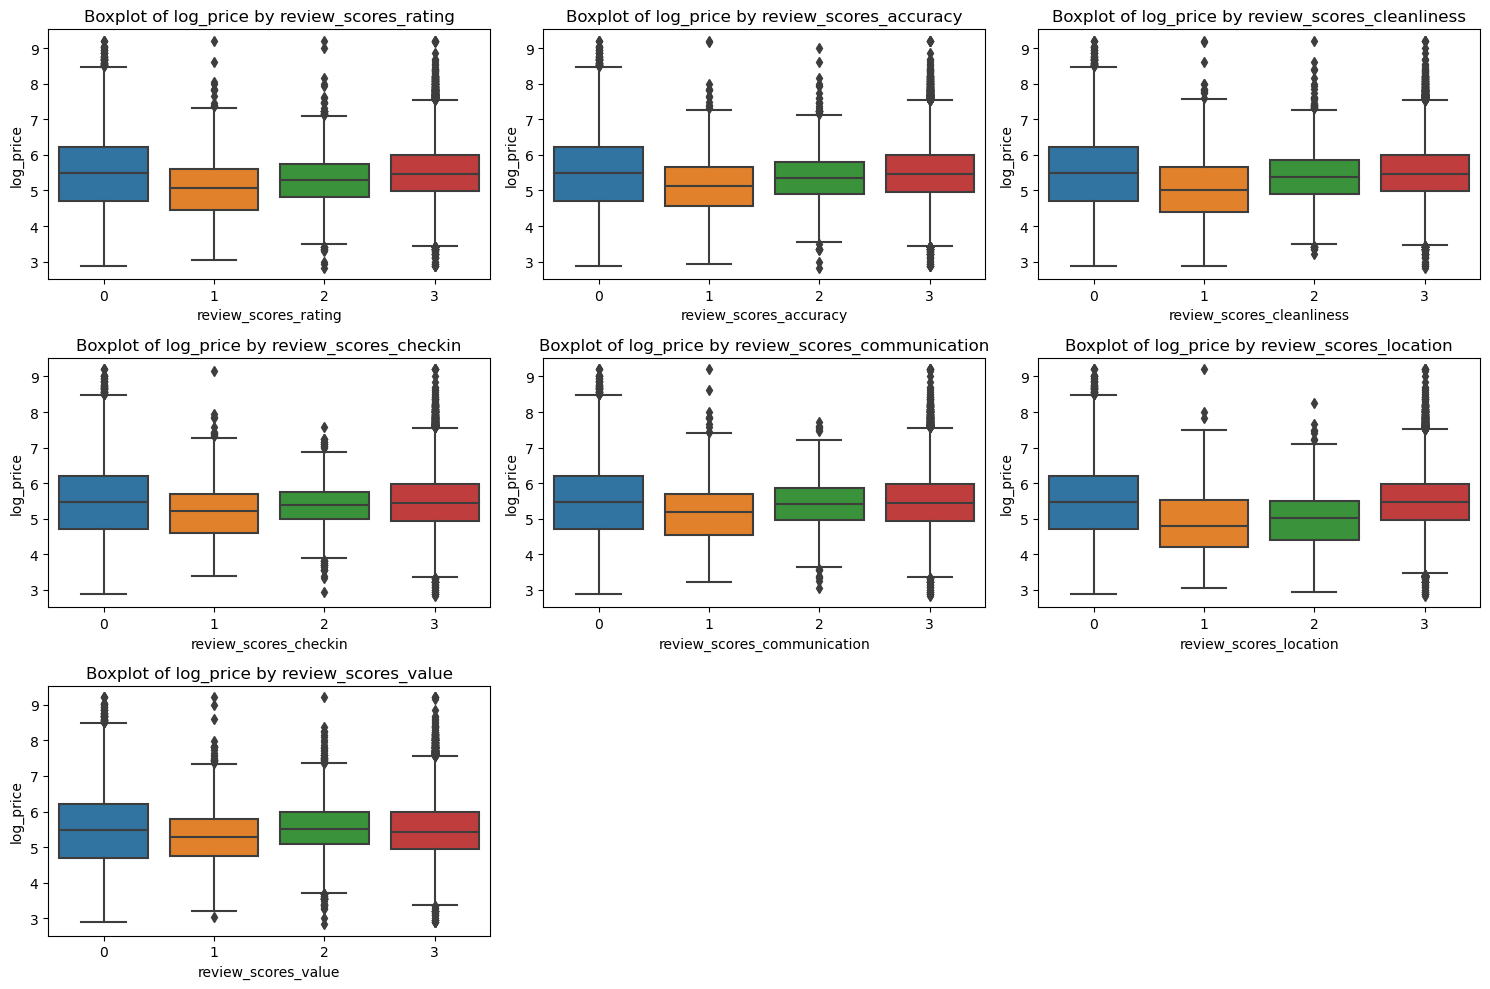

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(score_columns):
    sns.boxplot(x=col, y='log_price', data=df_airbnb, ax=axes[idx])
    axes[idx].set_title(f'Boxplot of log_price by {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('log_price')

fig.delaxes(axes[-2])
fig.delaxes(axes[-1])
    
plt.tight_layout()
plt.show()

In [19]:
# bathroom
def extract_bathroom_number(text):
    if isinstance(text, str):  # Check if the input is a string type
        if 'half-bath' in text.lower():  # Handle all types of half-bath
            return 0.5
        else:
            # Extract the numeric part
            number = ''.join(c for c in text if c.isdigit() or c == '.')
            return float(number) if number else np.nan  # Convert to float, return NaN if no number extracted
    return np.nan  # Return NaN if input is not a string (e.g., NaN)

# Apply the custom function to the 'bathrooms_text' column
df_airbnb['bathrooms'] = df_airbnb['bathrooms_text'].apply(extract_bathroom_number)

# Handle missing values (if any)
df_airbnb['bathrooms'] = df_airbnb['bathrooms'].fillna(df_airbnb['bathrooms'].mode()[0])

# Drop the original bathrooms_text column
df_airbnb = df_airbnb.drop(columns=['bathrooms_text'])


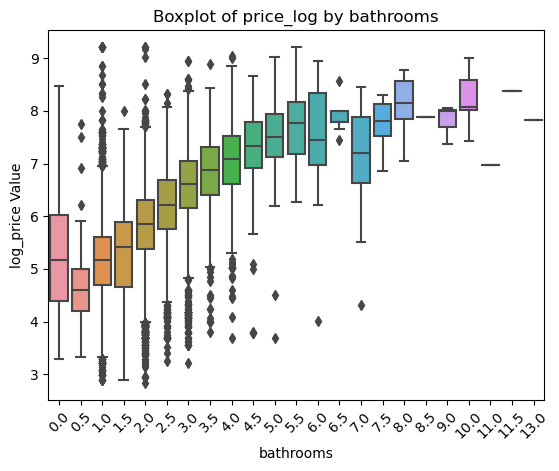

In [20]:
sns.boxplot(x='bathrooms', y='log_price', data=df_airbnb)
plt.title('Boxplot of price_log by bathrooms')
plt.xlabel('bathrooms')
plt.ylabel('log_price Value')
plt.xticks(rotation=45)

plt.show()

In [21]:
# beds
df_airbnb['beds'] = df_airbnb['beds'].fillna(df_airbnb['accommodates'].median())

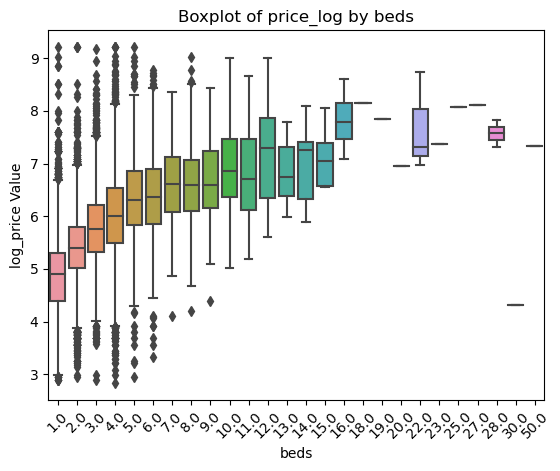

In [22]:
sns.boxplot(x='beds', y='log_price', data=df_airbnb)
plt.title('Boxplot of price_log by beds')
plt.xlabel('beds')
plt.ylabel('log_price Value')
plt.xticks(rotation=45)
plt.show()

In [23]:
# availability_days
availability_days = ['availability_30', 'availability_60', 'availability_90', 'availability_365']

def rescale(x):
    if x == 0:
        return 0
    else:
        return 1

for i in availability_days:
    df_airbnb[i] = df_airbnb[i].astype('int').apply(rescale)


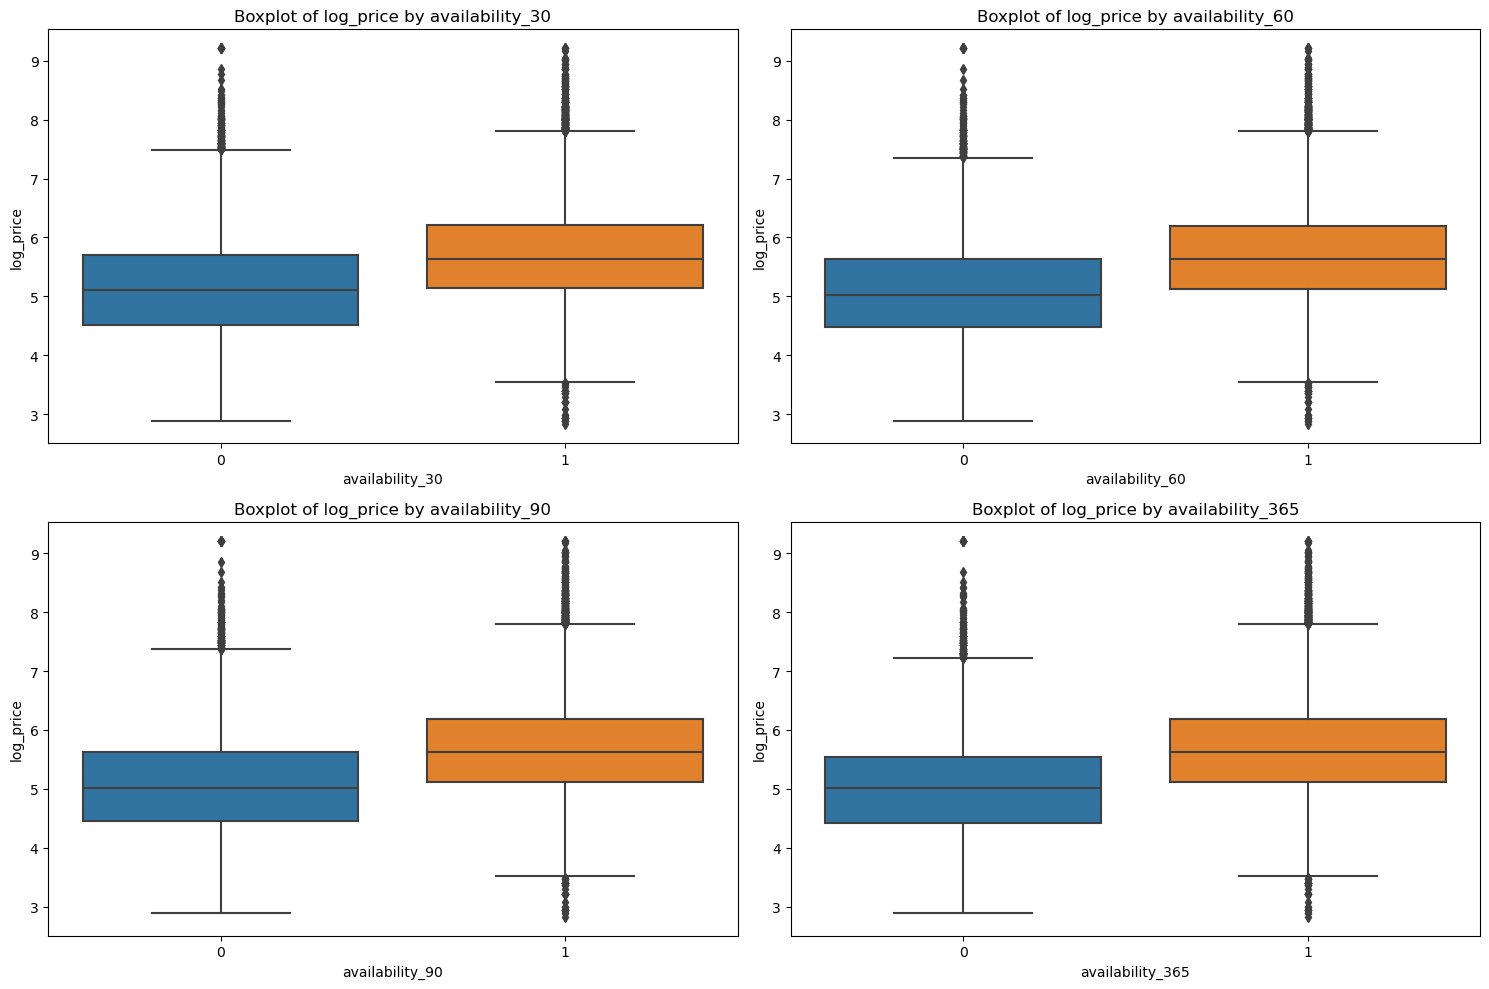

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(availability_days):
    sns.boxplot(x=col, y='log_price', data=df_airbnb, ax=axes[idx])
    axes[idx].set_title(f'Boxplot of log_price by {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('log_price')
    
plt.tight_layout()
plt.show()

In [25]:
# number_of_reviews
df_airbnb['number_of_reviews'].describe()

count    35609.000000
mean        28.818361
std         64.136142
min          0.000000
25%          1.000000
50%          5.000000
75%         26.000000
max       1116.000000
Name: number_of_reviews, dtype: float64

In [26]:
def reclassify_reviews(x):
    if x == 0:
        return 0
    elif 1 <= x <= 5:
        return 1
    elif 6 <= x <= 26:
        return 2
    else:
        return 3

df_airbnb['review_category'] = df_airbnb['number_of_reviews'].apply(reclassify_reviews)

In [27]:
# host_response_rate
df_airbnb['host_response_rate'] = df_airbnb['host_response_rate'].astype(str).str.strip('%').astype(float)
df_airbnb['host_response_rate'] = df_airbnb['host_response_rate'].fillna(0)

## Boolean Variable

In [28]:
boolean_data = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
                 'has_availability', 'instant_bookable']

for i in boolean_data:
    print(f"{i} value counts:")
    print(df_airbnb[i].value_counts())
    print()

host_is_superhost value counts:
f    27041
t     8542
Name: host_is_superhost, dtype: int64

host_has_profile_pic value counts:
t    35057
f      552
Name: host_has_profile_pic, dtype: int64

host_identity_verified value counts:
t    32413
f     3196
Name: host_identity_verified, dtype: int64

has_availability value counts:
t    27473
f     8136
Name: has_availability, dtype: int64

instant_bookable value counts:
f    24161
t    11448
Name: instant_bookable, dtype: int64



In [29]:
df_airbnb['host_is_superhost'] = df_airbnb['host_is_superhost'].fillna('f')

for i in boolean_data:
    df_airbnb[i] = (df_airbnb[i] == 't').astype(int)


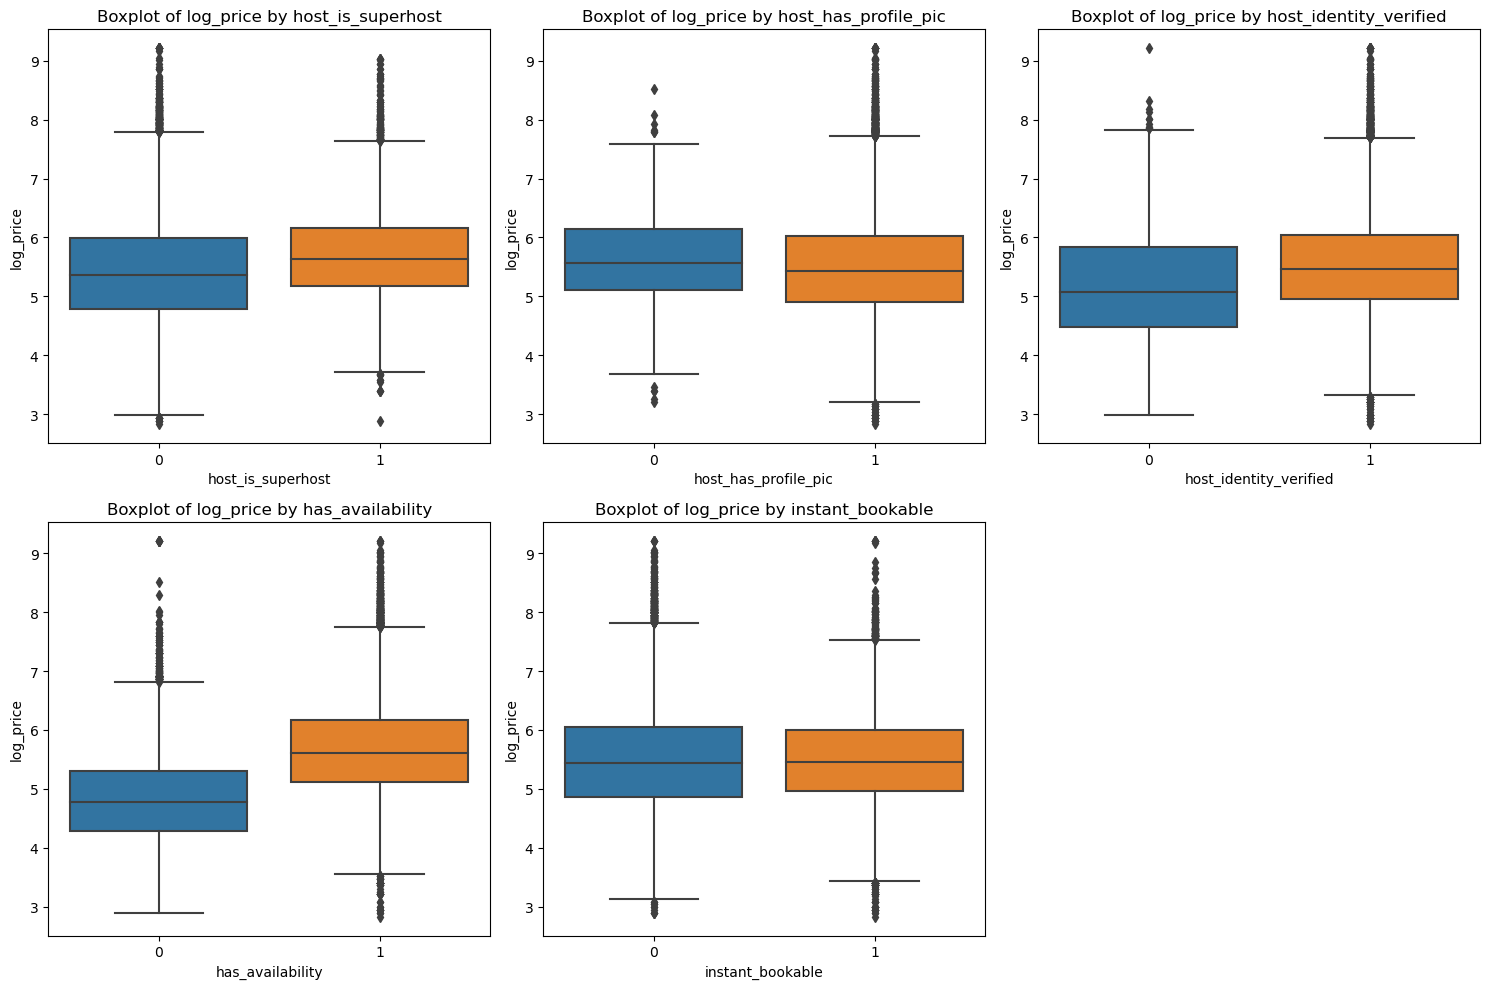

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(boolean_data):
    sns.boxplot(x=col, y='log_price', data=df_airbnb, ax=axes[idx])
    axes[idx].set_title(f'Boxplot of log_price by {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('log_price')
    
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

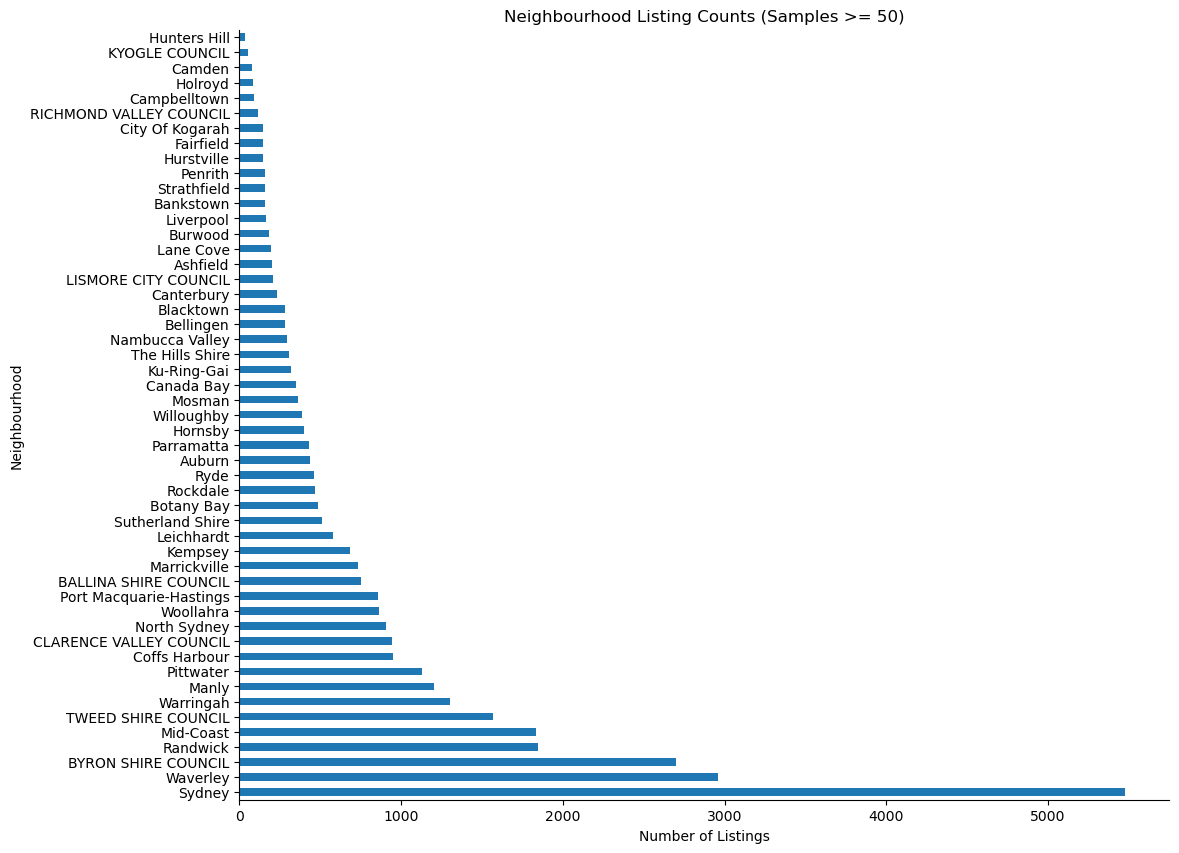

In [31]:
# Count the number of listings in each neighbourhood
neighbourhood_counts = df_airbnb['neighbourhood_cleansed'].value_counts()

# # Filter out neighbourhoods with at least 50 listings
# sufficient_neighbourhoods = neighbourhood_counts[neighbourhood_counts >= 50]

# Plot a horizontal bar chart
plt.figure(figsize=(12, 10))
neighbourhood_counts.plot(kind='barh')
sns.despine()
plt.title('Neighbourhood Listing Counts (Samples >= 50)')
plt.xlabel('Number of Listings')
plt.ylabel('Neighbourhood')
plt.show()


## Nominal Variable 

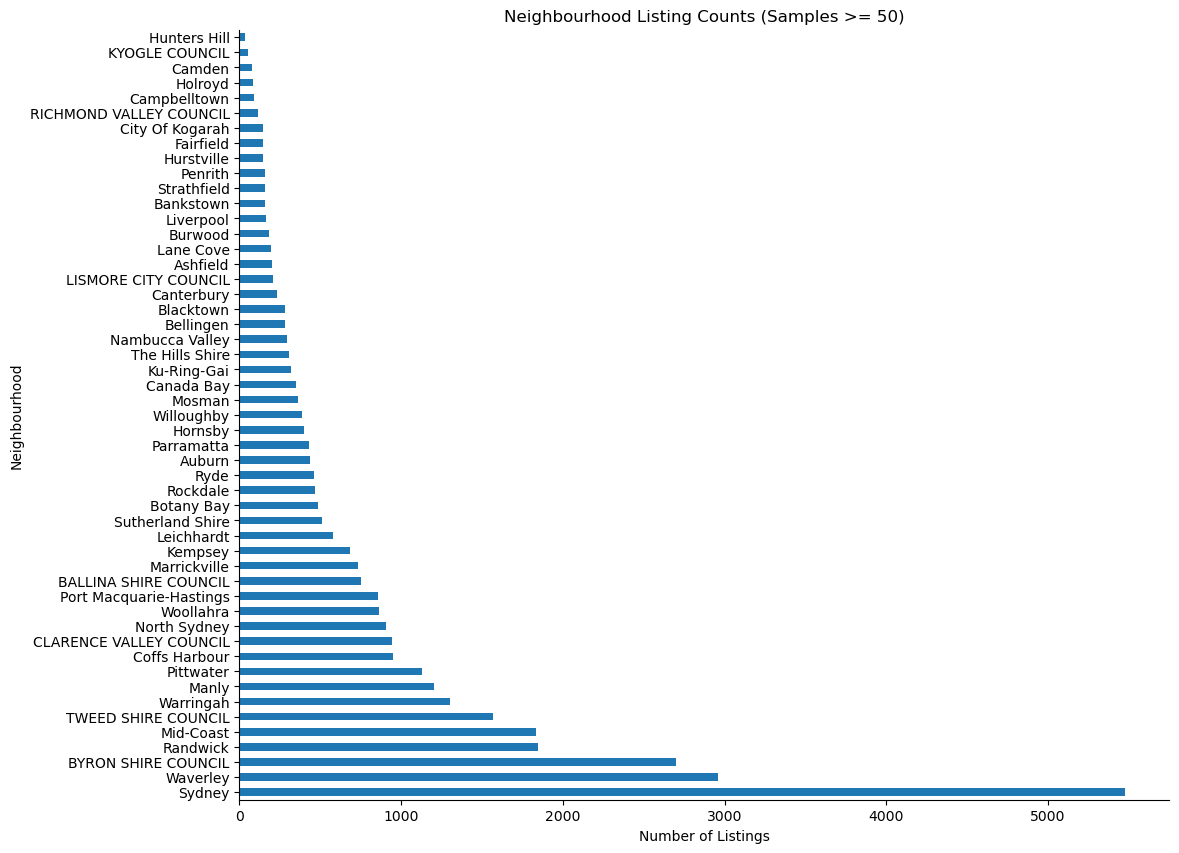

In [32]:
# Count the number of listings in each neighbourhood
neighbourhood_counts = df_airbnb['neighbourhood_cleansed'].value_counts()

# # Filter out neighbourhoods with at least 50 listings
# sufficient_neighbourhoods = neighbourhood_counts[neighbourhood_counts >= 50]

# Plot a horizontal bar chart
plt.figure(figsize=(12, 10))
neighbourhood_counts.plot(kind='barh')
sns.despine()
plt.title('Neighbourhood Listing Counts (Samples >= 50)')
plt.xlabel('Number of Listings')
plt.ylabel('Neighbourhood')
plt.show()


In [33]:
# Process the property_type column to keep only the last word
df_airbnb['property_type'] = df_airbnb['property_type'].apply(lambda x: x.split()[-1]) 
print(df_airbnb['property_type'].value_counts())


unit          15826
home          12462
suite          1149
townhouse      1078
guesthouse      980
condo           738
villa           473
cottage         463
hotel           431
apartment       419
cabin           342
stay            321
breakfast       159
bungalow        153
loft            138
Camper/RV        53
place            51
hostel           50
aparthotel       47
Tent             29
chalet           23
Barn             22
park             18
room             17
Campsite         16
resort           13
Boat             12
Treehouse        11
Dome             11
particular       10
tent              9
Ranch             9
camper/rv         8
home/apt          8
Yurt              7
Island            6
tipi              6
Hut               6
Bus               5
container         4
Train             4
lodge             3
barn              3
ranch             2
Houseboat         2
Tipi              2
yurt              2
treehouse         1
Lighthouse        1
Castle            1


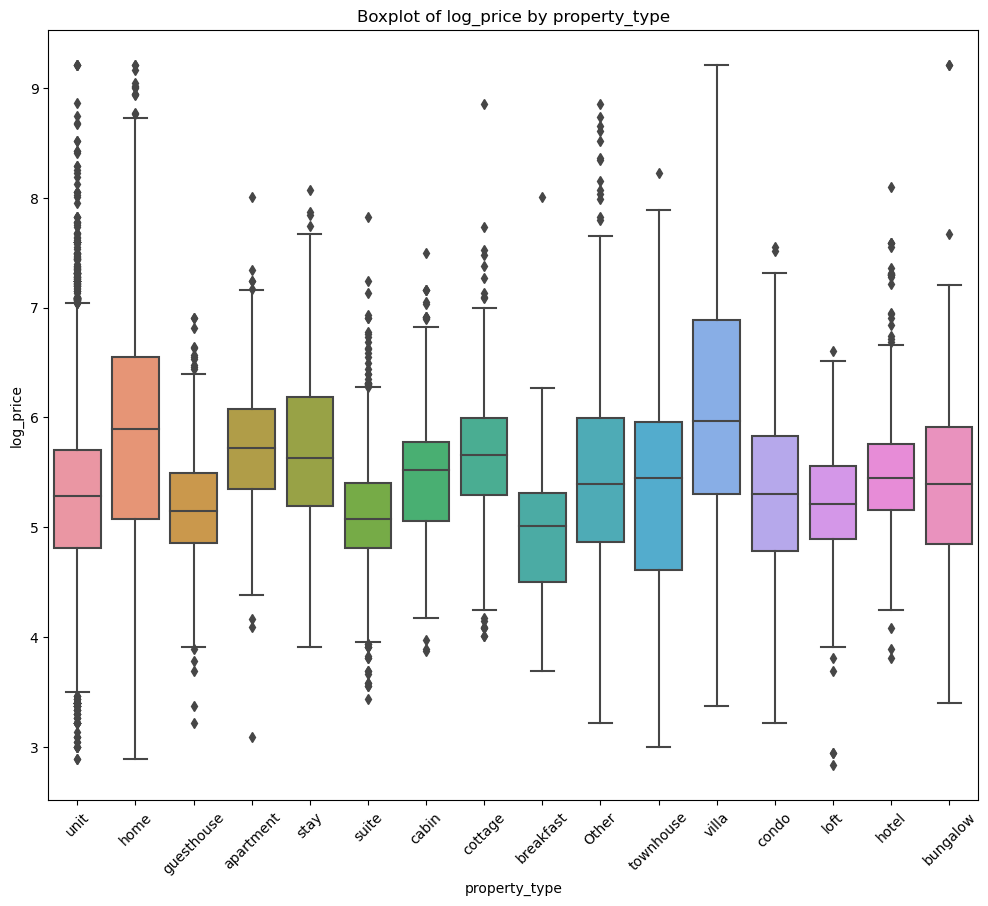

In [34]:
# Handle rare categories by replacing them with 'Other' (categories with fewer than 100 occurrences)
variable = 'property_type'
counts = df_airbnb[variable].value_counts()
for level in counts.index:
    if counts[level] < 100:
        df_airbnb.loc[df_airbnb[variable] == level, variable] = 'Other'

# Plot a boxplot for property_type
plt.figure(figsize=(12, 10))
sns.boxplot(x=df_airbnb['property_type'], y=df_airbnb['log_price'])
plt.title('Boxplot of log_price by property_type')
plt.xlabel('property_type')
plt.ylabel('log_price')
plt.xticks(rotation=45)
plt.show()


In [35]:
# View all unique categories in the room_type column and their occurrence counts
room_type_counts = df_airbnb['room_type'].value_counts()
print(room_type_counts)

Entire home/apt    28092
Private room        7181
Shared room          226
Hotel room           110
Name: room_type, dtype: int64


## Text

In [36]:
# python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

In [37]:
df_airbnb['neighborhood_overview'] = df_airbnb['neighborhood_overview'].fillna('NA')

In [38]:
def tokenizer(text):  
    # Replace urls with a special token
    text = re.sub('https?\S+', 'xxurl', text) 
    text = re.sub('\S*www[.]\S+', 'xxurl', text)

    text = re.sub('<br />',' ', text)
    text = re.sub('<b>',' ', text)
    text = re.sub('</b>',' ', text)
    text = re.sub('\t',' ', text)

    # Replace emoticons with special tokens
    text = re.sub(r'<3', 'xxheart', text) 
    text = re.sub(r'&lt;3', 'xxheart', text)
    
    eyes = r'[8:=;]'
    nose = r'[\'`-]*'
    text = re.sub(eyes + nose + r'[)D]+', 'xxsmile', text)
    text = re.sub(eyes + nose + r'[(]+', 'xxsadface', text)
    text = re.sub(eyes + nose + r'p+', 'xxlolface', text)
    text = re.sub(eyes + nose + r'[|/\\]+', 'xxneutralface', text)

    # Creating a special token for hashtags
    text = re.sub(r'#(\S+)', 'xxhashtag ' + r'\1', text) # hashtag
    
    # Stripping repeated whitespace
    text = re.sub(r'\s{2,}', ' ', text)
    
    doc = nlp(text) 
    tokens = []
    
    for token in doc:  
        word = token.lemma_.lower()
        if not token.is_stop:          
            if word == '!': 
                tokens.append('!')                     
            elif token.like_num:
                tokens.append('xxnumber')        
            elif (not token.is_punct) and word != '️':
                tokens.append(word)
                
    return tokens

df_airbnb['neighborhood_overview'] = df_airbnb['neighborhood_overview'].apply(tokenizer)

In [39]:
def identity_tokenizer(text):
    return text
    
tfidf = TfidfVectorizer(
    tokenizer=identity_tokenizer,
    max_features=100,
    max_df=0.9,
    stop_words='english',
    lowercase=False,
    ngram_range=(2, 2)
)


# Train Test Split 

In [40]:
# Train Test Split
index_train, index_test = train_test_split(df_airbnb.index, train_size=0.8, random_state=42)

train = df_airbnb.loc[index_train, :].copy()
test = df_airbnb.loc[index_test, :].copy()

y_train = train['log_price'].to_numpy()  
y_test = test['log_price'].to_numpy()

train.drop(columns=['log_price'], inplace=True)
test.drop(columns=['log_price'], inplace=True)

# Encoder

## Encoder

In [41]:
# Prepare KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare the feature columns that need encoding
target_encoded_columns = ['neighbourhood_cleansed', 'property_type']
one_hot_encoded_columns = ['room_type']

# Prepare DataFrames to store encoded results
train_encoded = train.copy().reset_index(drop=True)  # Use only the training set and reset index
test_encoded = test.copy()  # Directly use the test set

# Use KFold for cross-validation and perform encoding on each fold
for train_index, val_index in kf.split(train_encoded):
    X_train, X_val = train_encoded.iloc[train_index], train_encoded.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Apply target encoding
    encoder = TargetEncoder(cols=target_encoded_columns)
    # Fit the encoder on the training set of each fold and transform both the training and validation sets
    X_train_encoded = encoder.fit_transform(X_train[target_encoded_columns], y_train_fold)
    X_val_encoded = encoder.transform(X_val[target_encoded_columns])
    
    # Update the encoded columns in the training and validation sets
    X_train.loc[:, target_encoded_columns] = X_train_encoded
    X_val.loc[:, target_encoded_columns] = X_val_encoded


In [42]:
# Perform one-hot encoding
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
one_hot_encoder.fit(train_encoded[one_hot_encoded_columns])

# Encode the training and test sets separately
train_one_hot = one_hot_encoder.transform(train_encoded[one_hot_encoded_columns])
test_one_hot = one_hot_encoder.transform(test_encoded[one_hot_encoded_columns])

# Get the names of the encoded columns and merge them back into the dataset
encoded_columns = one_hot_encoder.get_feature_names_out(one_hot_encoded_columns)
train_one_hot_df = pd.DataFrame(train_one_hot, columns=encoded_columns, index=train_encoded.index)
test_one_hot_df = pd.DataFrame(test_one_hot, columns=encoded_columns, index=test_encoded.index)

# Merge the encoded features back into the original dataset
train_encoded = pd.concat([train_encoded.drop(one_hot_encoded_columns, axis=1), train_one_hot_df], axis=1)
test_encoded = pd.concat([test_encoded.drop(one_hot_encoded_columns, axis=1), test_one_hot_df], axis=1)


## TF-IDF

In [43]:
# Handle text features (TF-IDF)
train['neighborhood_overview'].fillna('', inplace=True)
test['neighborhood_overview'].fillna('', inplace=True)

# Ensure the neighborhood_overview column is of string type
train['neighborhood_overview'] = train['neighborhood_overview'].astype(str)
test['neighborhood_overview'] = test['neighborhood_overview'].astype(str)

# Fit the TF-IDF model and transform the data
tfidf = TfidfVectorizer()  # Ensure tfidf is defined here
tfidf.fit(train['neighborhood_overview'])
train_text = tfidf.transform(train['neighborhood_overview']).todense()
test_text = tfidf.transform(test['neighborhood_overview']).todense()

# Convert the TF-IDF matrix to a DataFrame
name_list = tfidf.get_feature_names_out()
train_text = pd.DataFrame(train_text, columns=name_list, index=train.index)
test_text = pd.DataFrame(test_text, columns=name_list, index=test.index)


In [44]:
# Select numerical features (excluding already encoded categorical features)
numerical_features = ['host_response_rate', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 
                      'accommodates', 'beds', 'has_availability', 'availability_30', 
                      'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 
                      'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                      'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                      'review_scores_value', 'calculated_host_listings_count', 'bathrooms']

# Reset index
train_text.reset_index(drop=True, inplace=True)
train_encoded.reset_index(drop=True, inplace=True)
test_text.reset_index(drop=True, inplace=True)
test_encoded.reset_index(drop=True, inplace=True)

# Merge text features with numerical features
train_combined = pd.concat([train_text, train_encoded[numerical_features].reset_index(drop=True)], axis=1)
test_combined = pd.concat([test_text, test_encoded[numerical_features]], axis=1)

# Standardize numerical features
scaler = StandardScaler()
train_combined[numerical_features] = scaler.fit_transform(train_combined[numerical_features])
test_combined[numerical_features] = scaler.transform(test_combined[numerical_features])

# Add target variable log_price
train_combined['log_price'] = y_train
test_combined['log_price'] = y_test


In [45]:
print("Train Combined Shape:", train_combined.shape)
print("Test Combined Shape:", test_combined.shape)

Train Combined Shape: (28487, 14866)
Test Combined Shape: (7122, 14866)


# Model

In [46]:
predictors = train_combined.columns.to_list()
target = 'log_price'

predictors.remove(target)

# Split the data into training and validation indices
index_train, index_validation = train_test_split(train_combined.index, train_size=0.8, random_state=42)

train_set = train_combined.loc[index_train, :].copy()
validation_set = train_combined.loc[index_validation, :].copy()

X_train = train_set[predictors]  # Training set features
X_validation = validation_set[predictors]  # Validation set features

y_train = train_set[target].values  # Training set target variable
y_validation = validation_set[target].values  # Validation set target variable


## PCA

In [47]:
num_samples, num_features = X_train.shape

print(f"The raw data has {num_samples} samples and {num_features} features.")

The raw data has 22789 samples and 14865 features.


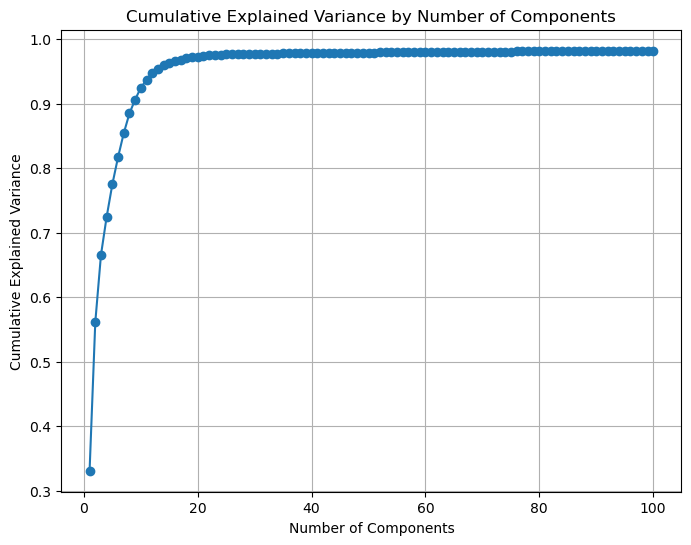

In [48]:
n_components = 100  # Assume selecting 100 principal components
pca = PCA(n_components=n_components, random_state=42)
pca.fit(X_train)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance curve
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, n_components + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.grid(True)
plt.show()


In [49]:
def apply_pca(X_train, X_validation, n_components=100):
    pca = PCA(n_components=n_components, svd_solver='randomized', random_state=42)
    X_train_reduced = pca.fit_transform(X_train)
    X_validation_reduced = pca.transform(X_validation)
    return X_train_reduced, X_validation_reduced

X_train_reduced, X_validation_reduced = apply_pca(X_train, X_validation, n_components=100)

## Linear Model

### Ridge

In [50]:
# Perform regression using RidgeCV
alphas = [0.1, 1.0, 10.0]  
ridge_model = RidgeCV(alphas=alphas, cv=5)  # Use 5-fold cross-validation
ridge_model.fit(X_train_reduced, y_train)  # Train the model

# Predict on the validation set
y_pred_ridge = ridge_model.predict(X_validation_reduced)

# Calculate MSE and R² for the model
mse_ridge = mean_squared_error(y_validation, y_pred_ridge)
r2_ridge = r2_score(y_validation, y_pred_ridge)
rmse_ridge = mean_squared_error(y_validation, y_pred_ridge, squared=False)

# Output results
print(f'Ridge Regression - MSE: {mse_ridge:.4f}, RMSE: {rmse_ridge:.4f}, R²: {r2_ridge:.4f}')
print(f'Best alpha selected by RidgeCV: {ridge_model.alpha_}')


Ridge Regression - MSE: 0.3267, RMSE: 0.5715, R²: 0.5820
Best alpha selected by RidgeCV: 1.0


### Lasso

In [51]:
# Perform regression using LassoCV
alphas = [0.01, 0.1, 1.0, 10.0]  
lasso_model = LassoCV(alphas=alphas, cv=5)  # Use 5-fold cross-validation
lasso_model.fit(X_train_reduced, y_train)  # Train the model

# Predict on the validation set
y_pred_lasso = lasso_model.predict(X_validation_reduced)

# Calculate MSE and R² for the model
mse_lasso = mean_squared_error(y_validation, y_pred_lasso)
r2_lasso = r2_score(y_validation, y_pred_lasso)
rmse_lasso = mean_squared_error(y_validation, y_pred_lasso, squared=False)

# Output results
print(f'Lasso Regression with PCA - MSE: {mse_lasso:.4f}, RMSE: {rmse_lasso:.4f}, R²: {r2_lasso:.4f}')
print(f'Best alpha selected by LassoCV: {lasso_model.alpha_}')


Lasso Regression with PCA - MSE: 0.3633, RMSE: 0.6027, R²: 0.5352
Best alpha selected by LassoCV: 0.01


### Elastic Net

In [52]:
# Perform regression using ElasticNetCV
alphas = [0.01, 0.1, 1.0, 10.0] 
elastic_net_model = ElasticNetCV(alphas=alphas, l1_ratio=[0.1, 0.5, 0.9], cv=5, random_state=42)
elastic_net_model.fit(X_train_reduced, y_train)  # Train the model

# Predict on the validation set
y_pred_elastic = elastic_net_model.predict(X_validation_reduced)

# Calculate MSE and R² for the model
mse_elastic = mean_squared_error(y_validation, y_pred_elastic)
r2_elastic = r2_score(y_validation, y_pred_elastic)
rmse_elastic = mean_squared_error(y_validation, y_pred_elastic, squared=False)

# Output results
print(f'ElasticNet Regression with PCA - MSE: {mse_elastic:.4f}, RMSE: {rmse_elastic:.4f}, R²: {r2_elastic:.4f}')
print(f'Best alpha selected by ElasticNetCV: {elastic_net_model.alpha_}')
print(f'Best l1_ratio selected by ElasticNetCV: {elastic_net_model.l1_ratio_}')


ElasticNet Regression with PCA - MSE: 0.3462, RMSE: 0.5884, R²: 0.5571
Best alpha selected by ElasticNetCV: 0.01
Best l1_ratio selected by ElasticNetCV: 0.1


## Tree Model

### Single Decision Tree

In [53]:
# Apply PCA for dimensionality reduction
X_train_pca, X_validation_pca = apply_pca(X_train, X_validation, n_components=100)

# Initialize the decision tree model
tree_model = DecisionTreeRegressor(random_state=42)

# Perform hyperparameter tuning with random search
param_dist = {
    'max_depth': [None] + list(range(5, 31)),
    'min_samples_split': range(2, 21),  
    'min_samples_leaf': range(1, 6),  
    'max_features': ['auto', 'sqrt', 'log2', None],  
    'criterion': ['mse', 'friedman_mse'],  
    'splitter': ['best', 'random']  
}

random_search = RandomizedSearchCV(
    tree_model, 
    param_distributions=param_dist, 
    n_iter=100,  
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    random_state=42
)
random_search.fit(X_train_pca, y_train)

# Get the best model
best_tree_model = random_search.best_estimator_

# Predict on the validation set
y_pred_tree = best_tree_model.predict(X_validation_pca)

# Calculate MSE and R² for the model
mse_tree = mean_squared_error(y_validation, y_pred_tree)
r2_tree = r2_score(y_validation, y_pred_tree)
rmse_tree = mean_squared_error(y_validation, y_pred_tree, squared=False)

# Output results
print(f'Decision Tree with PCA - MSE: {mse_tree:.4f}, RMSE: {rmse_tree:.4f}, R²: {r2_tree:.4f}')
print(f'Best Parameters: {random_search.best_params_}')


Decision Tree with PCA - MSE: 0.3338, RMSE: 0.5777, R²: 0.5729
Best Parameters: {'splitter': 'best', 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 6, 'criterion': 'friedman_mse'}


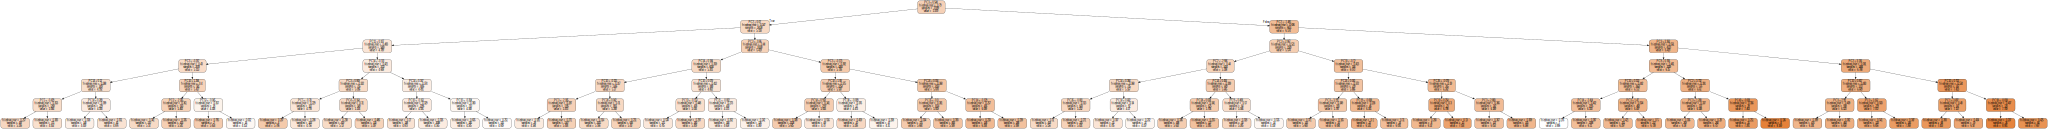

In [54]:
pca_feature_names = [f'PC{i+1}' for i in range(100)]

dot_data = export_graphviz(
    best_tree_model, 
    out_file=None, 
    impurity=True,  
    feature_names=pca_feature_names,  
    filled=True,  
    rounded=True,  
    special_characters=True
)

graph = graphviz.Source(dot_data)
output_filename = "decision_tree"
output_format = "png" 
graph.render(filename=output_filename, format=output_format, cleanup=True)
graph

### Bagging

In [55]:
# 6. Build the Bagging model
bagging_model = BaggingRegressor(
    base_estimator=best_tree_model,
    n_estimators=200,  
    max_samples=0.8,  
    max_features=0.8,  
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

# 7. Train the Bagging model
bagging_model.fit(X_train_pca, y_train)

# 8. Predict on the validation set
y_pred_bagging = bagging_model.predict(X_validation_pca)

# 9. Calculate MSE and R² for the Bagging model
mse_bagging = mean_squared_error(y_validation, y_pred_bagging)
r2_bagging = r2_score(y_validation, y_pred_bagging)
rmse_bagging = mean_squared_error(y_validation, y_pred_bagging, squared=False)

# Output results
print(f'Bagging with PCA - MSE: {mse_bagging:.4f}, RMSE: {rmse_bagging:.4f}, R²: {r2_bagging:.4f}')


Bagging with PCA - MSE: 0.3139, RMSE: 0.5603, R²: 0.5984


### Radom Forest

In [56]:
rf_model = RandomForestRegressor(
    n_estimators=200,  
    max_depth=15,  
    min_samples_split=10, 
    min_samples_leaf=4,  
    max_features='sqrt',  
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

# 11. Train the Random Forest model
rf_model.fit(X_train_pca, y_train)

# 12. Predict on the validation set
y_pred_rf = rf_model.predict(X_validation_pca)

# 13. Calculate MSE and R² for the Random Forest model
mse_rf = mean_squared_error(y_validation, y_pred_rf)
r2_rf = r2_score(y_validation, y_pred_rf)
rmse_rf = mean_squared_error(y_validation, y_pred_rf, squared=False)

# Output results
print(f'Random Forest with PCA - MSE: {mse_rf:.4f}, RMSE: {rmse_rf:.4f}, R²: {r2_rf:.4f}')


Random Forest with PCA - MSE: 0.2968, RMSE: 0.5448, R²: 0.6202


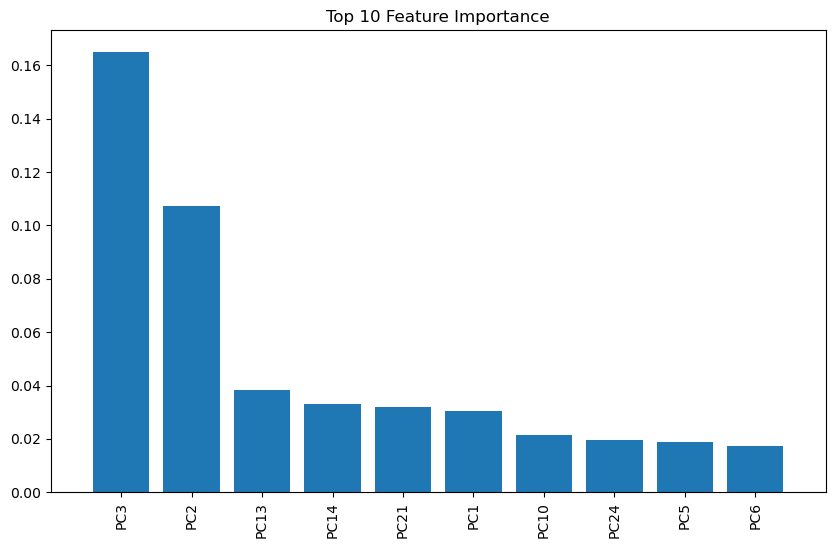

In [57]:
# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10
indices_top_n = indices[:top_n]

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importance")
plt.bar(range(top_n), importances[indices_top_n], align="center")
plt.xticks(range(top_n), [f'PC{i+1}' for i in indices_top_n], rotation=90)
plt.xlim([-1, top_n])
plt.show()


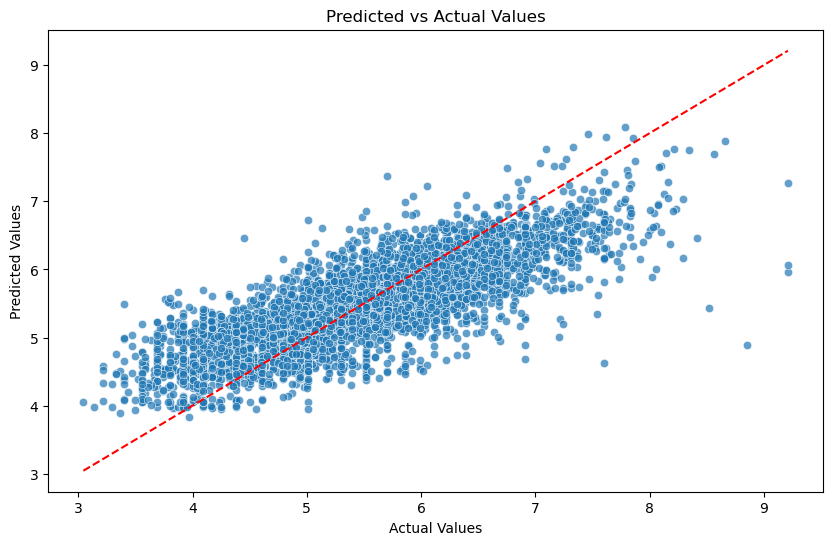

In [58]:
# Plot the relationship between predicted and actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_validation, y_pred_rf, alpha=0.7, edgecolors="w", linewidth=0.5)
plt.plot([min(y_validation), max(y_validation)], [min(y_validation), max(y_validation)], color='r', linestyle='--')
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()


## Boosting

### CatBoosting

In [59]:
# 1. Create data pools (create once and reuse)
train_pool = Pool(data=X_train, label=y_train)
validation_pool = Pool(data=X_validation, label=y_validation)

# 2. Define initial parameters
catboosting_base_params = {
    'iterations': 2000,
    'learning_rate': 0.01,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'verbose': 100,
}


In [60]:
# 3. Use Optuna for hyperparameter optimization
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 2, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_uniform('random_strength', 0.0, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        **catboosting_base_params  # Merge base parameters
    }

    model = CatBoostRegressor(**params)
    model.fit(
        train_pool,
        eval_set=validation_pool,
        early_stopping_rounds=100,
        use_best_model=True,
        verbose=0
    )
    
    # Get RMSE for the validation set
    rmse = model.get_best_score()['validation']['RMSE']
    
    # Store parameters and best iteration count
    trial.set_user_attr("params", params)
    trial.set_user_attr("iterations", model.best_iteration_)

    return rmse

# 4. Set up the Optuna sampler and start optimization
sampler = TPESampler(seed=42)  
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=20, timeout=600)

# Output the best result
print('Best trial:')
print(f'  Value: {study.best_trial.value}')
print(f'  Params: {study.best_trial.user_attrs["params"]}')
print(f'  Best Iterations: {study.best_trial.user_attrs["iterations"]}')


[I 2024-10-28 17:34:18,659] A new study created in memory with name: no-name-ecb258b8-ddaa-4cd6-b798-090ac3adaa88
[I 2024-10-28 17:36:28,301] Trial 0 finished with value: 0.5203403708353063 and parameters: {'depth': 5, 'l2_leaf_reg': 3.6010467344475403, 'bagging_temperature': 0.7319939418114051, 'random_strength': 5.986584841970366, 'border_count': 66}. Best is trial 0 with value: 0.5203403708353063.
[I 2024-10-28 17:38:08,358] Trial 1 finished with value: 0.5304422083315391 and parameters: {'depth': 3, 'l2_leaf_reg': 3.3323645788192616e-08, 'bagging_temperature': 0.8661761457749352, 'random_strength': 6.011150117432088, 'border_count': 190}. Best is trial 0 with value: 0.5203403708353063.
[I 2024-10-28 17:39:22,286] Trial 2 finished with value: 0.5367035591506105 and parameters: {'depth': 2, 'l2_leaf_reg': 5.360294728728285, 'bagging_temperature': 0.8324426408004217, 'random_strength': 2.1233911067827616, 'border_count': 72}. Best is trial 0 with value: 0.5203403708353063.
[I 2024-10-

Best trial:
  Value: 0.5081567931958654
  Params: {'depth': 7, 'l2_leaf_reg': 1.8007140198129195e-07, 'bagging_temperature': 0.29214464853521815, 'random_strength': 3.663618432936917, 'border_count': 134, 'iterations': 2000, 'learning_rate': 0.01, 'loss_function': 'RMSE', 'eval_metric': 'RMSE', 'random_seed': 42, 'verbose': 100}
  Best Iterations: 1999


0:	learn: 0.8848951	test: 0.8804673	best: 0.8804673 (0)	total: 566ms	remaining: 18m 52s
100:	learn: 0.6580525	test: 0.6533652	best: 0.6533652 (100)	total: 35.4s	remaining: 11m 5s
200:	learn: 0.5938362	test: 0.5875613	best: 0.5875613 (200)	total: 1m 5s	remaining: 9m 41s
300:	learn: 0.5717665	test: 0.5653164	best: 0.5653164 (300)	total: 1m 30s	remaining: 8m 32s
400:	learn: 0.5613801	test: 0.5555008	best: 0.5555008 (400)	total: 2m	remaining: 8m 1s
500:	learn: 0.5551086	test: 0.5498003	best: 0.5498003 (500)	total: 2m 33s	remaining: 7m 40s
600:	learn: 0.5505241	test: 0.5457887	best: 0.5457887 (600)	total: 2m 58s	remaining: 6m 54s
700:	learn: 0.5469711	test: 0.5428046	best: 0.5428046 (700)	total: 3m 29s	remaining: 6m 27s
800:	learn: 0.5435520	test: 0.5400302	best: 0.5400302 (800)	total: 3m 50s	remaining: 5m 45s
900:	learn: 0.5402921	test: 0.5373977	best: 0.5373977 (900)	total: 4m 16s	remaining: 5m 13s
1000:	learn: 0.5369687	test: 0.5348097	best: 0.5348097 (1000)	total: 4m 50s	remaining: 4m 4

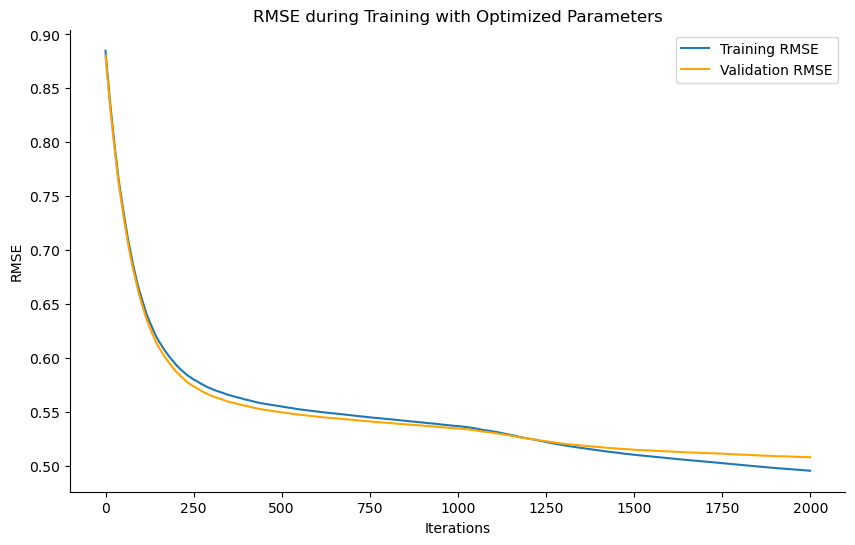

Validation RMSE: 0.5082


In [61]:
# 5. Retrain the model with optimized parameters
catboosting_best_params = study.best_trial.user_attrs['params']
catboosting_best_params.update({
    'iterations': study.best_trial.user_attrs['iterations'],
    **catboosting_base_params  # Retain base parameters
})

catboost_model = CatBoostRegressor(**catboosting_best_params)
catboost_model.fit(
    train_pool,
    eval_set=validation_pool,
    early_stopping_rounds=100,
    use_best_model=True,
    verbose=100
)

# 6. Get training results and plot the RMSE curve
catboosting_evals_result = catboost_model.get_evals_result()
iterations = range(len(catboosting_evals_result['validation']['RMSE']))

plt.figure(figsize=(10, 6))
plt.plot(iterations, catboosting_evals_result['learn']['RMSE'], label='Training RMSE')
plt.plot(iterations, catboosting_evals_result['validation']['RMSE'], label='Validation RMSE', color='orange')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('RMSE during Training with Optimized Parameters')
plt.legend()
sns.despine()
plt.show()

# Output the final RMSE for the validation set
catboosting_final_rmse = catboosting_evals_result['validation']['RMSE'][-1]
print(f'Validation RMSE: {catboosting_final_rmse:.4f}')


### XGboost

In [62]:
xgbst = xgb.XGBRegressor(objective='reg:squarederror', booster = 'gbtree', learning_rate = 0.02,
                        max_depth = 6, n_estimators = 1822, subsample = 0.60,  reg_lambda=0.0,
                        reg_alpha = 0.0, colsample_bytree = 1.0, min_child_weight = 1.0, random_state=42)



xgbst.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1822, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [63]:
y_pred_xgb = xgbst.predict(X_validation)


rmse_xgb = np.sqrt(mean_squared_error(y_validation, y_pred_xgb))
print(f'XGBoost RMSE: {rmse_xgb:.4}')

XGBoost RMSE: 0.4911


### Lightbgm

In [64]:
lgb_train_data = lgb.Dataset(X_train, y_train)

# Define the objective function for hyperparameter optimization
def objective(trial):

    params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'num_leaves': trial.suggest_int('num_leaves', 2, 64),
        'lambda_l1': trial.suggest_loguniform('lambda_l1',  1e-8, 10),
        'lambda_l2': trial.suggest_loguniform('lambda_l2',  1e-8, 10),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'feature_fraction':  trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 128),
        'feature_pre_filter': False,
        'verbosity': -1,
        'random_state': 42  # Ensure randomness
    }

    # Cross-validation
    history = lgb.cv(params, lgb_train_data, num_boost_round=5000,
                     nfold=5, stratified=False, callbacks=[lgb.early_stopping(stopping_rounds=50)])

    # Save hyperparameters and iteration count
    trial.set_user_attr('params', params)
    trial.set_user_attr('num_boost_round', len(history['valid l2-mean']))

    return history['valid l2-mean'][-1]  # Return cross-validation error

# Create and run Optuna optimization
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=500, timeout=120)


[I 2024-10-28 18:18:37,440] A new study created in memory with name: no-name-4886a3e6-9642-4657-8087-f75ef49025eb


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[5000]	cv_agg's valid l2: 0.245562 + 0.0124288


[I 2024-10-28 18:47:45,983] Trial 0 finished with value: 0.2455615423765313 and parameters: {'num_leaves': 25, 'lambda_l1': 3.6010467344475403, 'lambda_l2': 0.038720902953704193, 'bagging_fraction': 0.7993292420985183, 'bagging_freq': 2, 'feature_fraction': 0.5779972601681014, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.2455615423765313.


In [65]:
lgb_params = study.best_trial.user_attrs['params']
num_trees = study.best_trial.user_attrs['num_boost_round']

print(f'Number of boosting iterations: {num_trees} \n')

print('Best parameters:')
lgb_params

Number of boosting iterations: 5000 

Best parameters:


{'objective': 'regression',
 'boosting_type': 'gbdt',
 'learning_rate': 0.01,
 'num_leaves': 25,
 'lambda_l1': 3.6010467344475403,
 'lambda_l2': 0.038720902953704193,
 'bagging_fraction': 0.7993292420985183,
 'bagging_freq': 2,
 'feature_fraction': 0.5779972601681014,
 'min_data_in_leaf': 8,
 'feature_pre_filter': False,
 'verbosity': -1,
 'random_state': 42}

In [66]:
# Train the model with the best parameters
lgbm = lgb.LGBMRegressor(**lgb_params)  
lgbm = lgbm.fit(X_train, y_train)

# Predict on the validation set
y_pred_lgb = lgbm.predict(X_validation)

# Calculate RMSE
rmse_lgb = np.sqrt(mean_squared_error(y_validation, y_pred_lgb))
print(f'LightGBM RMSE: {rmse_lgb:.4}')


LightGBM RMSE: 0.6194


## Stacking Model

In [67]:
# Build base models
stacking_estimators = [('rf_model', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=40, n_jobs=-1)),
              ('lgbm', lgb.LGBMRegressor(n_estimators=100, max_depth=10, random_state=40, n_jobs=-1))]

# Build meta model
meta_model = ElasticNetCV(cv=3, random_state=42)

# Fit the stacking model
stack = StackingRegressor(estimators=stacking_estimators, final_estimator=meta_model)
stack.fit(X_train, y_train)


StackingRegressor(estimators=[('rf_model',
                               RandomForestRegressor(max_depth=10, n_jobs=-1,
                                                     random_state=40)),
                              ('lgbm',
                               LGBMRegressor(max_depth=10, n_jobs=-1,
                                             random_state=40))],
                  final_estimator=ElasticNetCV(cv=3, random_state=42))

In [68]:
y_pred_stack = stack.predict(X_validation)

rmse_stack = np.sqrt(mean_squared_error(y_validation, y_pred_stack))
print(f'Stacking RMSE: {rmse_stack:.4f}')

Stacking RMSE: 0.4990


## Final Model

In [113]:
# Predict using the test set
X_test = test_combined[predictors]  # Test set features
y_test = test_combined[target].values  # Test set target variable

# Predict log_price
y_pred_test = xgbst.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
print(f'Final Model Test RMSE: {rmse_test:.4f} R^2: {r2:.4f}')


Final Model Test RMSE: 0.5024 R^2: 0.6881


In [114]:
# Convert predicted log_price back to actual price
y_pred_actual = np.exp(y_pred_test)

# Convert actual log_price back to actual price
y_test_actual = np.exp(y_test)

mle = np.mean(np.abs(np.log(y_test_actual) - np.log(y_pred_actual)))
print(f'Mean Logarithmic Error (MLE): {mle:.4f}')


Mean Logarithmic Error (MLE): 0.3786


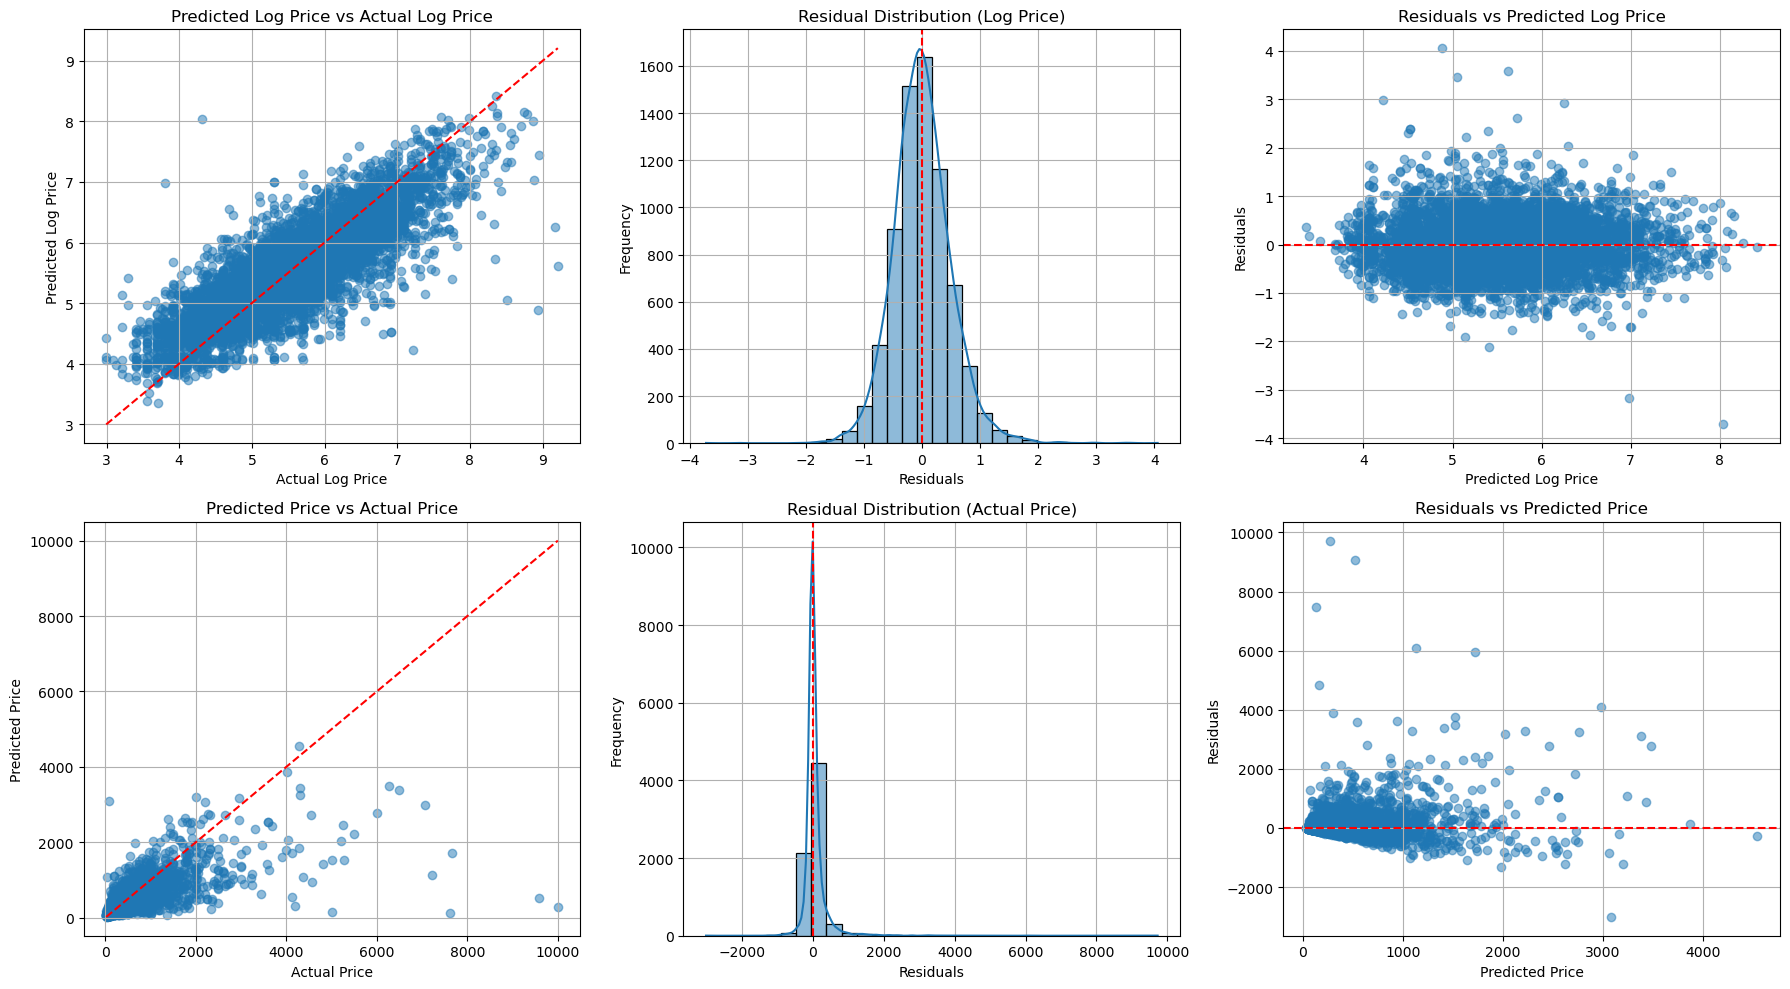

In [115]:
# Calculate residuals
residuals_log = y_test - y_pred_test  # Residuals for log_price
residuals_actual = y_test_actual - y_pred_actual  # Residuals for actual price

# Create subplots
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# First row: Predicted log_price vs. Actual log_price
ax[0, 0].scatter(y_test, y_pred_test, alpha=0.5)
ax[0, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ideal prediction line
ax[0, 0].set_title('Predicted Log Price vs Actual Log Price')
ax[0, 0].set_xlabel('Actual Log Price')
ax[0, 0].set_ylabel('Predicted Log Price')
ax[0, 0].grid()

# First row: Residual distribution for log_price
sns.histplot(residuals_log, kde=True, ax=ax[0, 1], bins=30)
ax[0, 1].set_title('Residual Distribution (Log Price)')
ax[0, 1].set_xlabel('Residuals')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].axvline(0, color='red', linestyle='--')  # Add zero line
ax[0, 1].grid()

# First row: Residuals vs. Predicted log_price
ax[0, 2].scatter(y_pred_test, residuals_log, alpha=0.5)
ax[0, 2].axhline(0, color='red', linestyle='--')
ax[0, 2].set_title('Residuals vs Predicted Log Price')
ax[0, 2].set_xlabel('Predicted Log Price')
ax[0, 2].set_ylabel('Residuals')
ax[0, 2].grid()

# Second row: Predicted price vs. Actual price
ax[1, 0].scatter(y_test_actual, y_pred_actual, alpha=0.5)
ax[1, 0].plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color='red', linestyle='--')  # Ideal prediction line
ax[1, 0].set_title('Predicted Price vs Actual Price')
ax[1, 0].set_xlabel('Actual Price')
ax[1, 0].set_ylabel('Predicted Price')
ax[1, 0].grid()

# Second row: Residual distribution for actual price
sns.histplot(residuals_actual, kde=True, ax=ax[1, 1], bins=30)
ax[1, 1].set_title('Residual Distribution (Actual Price)')
ax[1, 1].set_xlabel('Residuals')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].axvline(0, color='red', linestyle='--')  # Add zero line
ax[1, 1].grid()

# Second row: Residuals vs. Predicted price
ax[1, 2].scatter(y_pred_actual, residuals_actual, alpha=0.5)
ax[1, 2].axhline(0, color='red', linestyle='--')
ax[1, 2].set_title('Residuals vs Predicted Price')
ax[1, 2].set_xlabel('Predicted Price')
ax[1, 2].set_ylabel('Residuals')
ax[1, 2].grid()

# Ensure tidy layout
plt.tight_layout()
plt.show()
